### Load in the data, filter to the subset of interest

In [1]:
import pandas as pd
import numpy as np
# Load the data
data_path = "/Users/adamhunter/Documents/school projs/spring2024/trajectoryanalysis-1/OSPI data/processed data/clearinghouse_good_sample.csv"
filtered_data = pd.read_csv(data_path)

In [2]:
filtered_data.columns

Index(['Enrollment Begin', 'Enrollment End', '2-year / 4-year', 'Admit Type',
       'App Major 1', 'App Major 2', 'App Minor', 'Application Source',
       'Campus', 'Class Level', 'College Code/Branch', 'College Name',
       'College Sequence', 'College State', 'County', 'DHC', 'Degree CIP 1',
       'Degree CIP 2', 'Degree CIP 3', 'Degree CIP 4', 'Degree Major 1',
       'Degree Major 2', 'Degree Major 3', 'Degree Major 4', 'Degree Title',
       'EFC', 'Enrollment CIP 1', 'Enrollment CIP 2', 'Enrollment Major 1',
       'Enrollment Major 2', 'Enrollment Status', 'FAFSA Filed Date',
       'First Name', 'Graduated?', 'Graduation Date', 'Last Name',
       'Middle Initial', 'Name Suffix', 'Public / Private', 'Record Found Y/N',
       'Requester Return Field', 'Residency Code', 'Search Date', 'State',
       'Unique ID', 'Year', 'Your Unique Identifier', 'eSports'],
      dtype='object')

In [3]:
filtered_data = filtered_data[filtered_data['Campus'].isin(['University of Montana - On Campus'])]
filtered_data = filtered_data[(filtered_data['College Name'] != 'UNIVERSITY OF MONTANA') & (filtered_data['College Name'].notna())]

### Create a column for each student indicating whether their destination college state was the same as the state they applied from

In [4]:
# Create 'stayed_in_state' column
filtered_data['stayed_in_state'] = (filtered_data['State'].astype(str) == filtered_data['College State'].astype(str)).astype(int)

### Create groups by college, and create a 'document' out of the combined majors of all students enrolling

In [5]:
grouped = filtered_data.groupby('College Name')['Enrollment Major 1'].apply(lambda x: ' '.join(x.dropna().unique()))

### Calculate TF-IDF scores for top terms for each university, effectively answering 'what is the university known for'

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(grouped)

In [7]:
feature_names = vectorizer.get_feature_names_out()

In [8]:
top_terms = {}
for i, college in enumerate(grouped.index):
    sorted_indices = np.argsort(tfidf_matrix[i].toarray()).flatten()[::-1]
    top_terms[college] = [(feature_names[idx], tfidf_matrix[i, idx]) for idx in sorted_indices[:10]]

In [9]:
top_terms

{'AANIIIH NAKODA COLLEGE': [('certificate', 0.4819217636276786),
  ('welding', 0.44715529009149363),
  ('year', 0.4384428024906411),
  ('systems', 0.3958827432213948),
  ('information', 0.38717025562054225),
  ('computer', 0.26257859016218343),
  ('drama', 0.0),
  ('diversified', 0.0),
  ('diving', 0.0),
  ('division', 0.0)],
 'ABILENE CHRISTIAN UNIVERSITY': [('biochemistry', 0.620201619684689),
  ('kinesiology', 0.5745297703498744),
  ('marketing', 0.5341025125593484),
  ('dsci', 0.0),
  ('diving', 0.0),
  ('division', 0.0),
  ('documentary', 0.0),
  ('drafting', 0.0),
  ('drama', 0.0),
  ('dsgn', 0.0)],
 'ABRAHAM BALDWIN AGRICULTURAL COLLEGE': [('resource', 0.5657884816728304),
  ('agriculture', 0.5577582188880534),
  ('natural', 0.5049780727373417),
  ('management', 0.33732226330863435),
  ('drafting', 0.0),
  ('disorders', 0.0),
  ('distinguished', 0.0),
  ('diversified', 0.0),
  ('diving', 0.0),
  ('division', 0.0)],
 'ADAMS STATE UNIVERSITY': [('criminology', 0.5680607332692734),

### Add columns to the TF-IDF table indicating the number of enrollees from in state, the number from out of state, and the number of total

In [10]:
stayed_counts = filtered_data.groupby('College Name')['stayed_in_state'].value_counts().unstack(fill_value=0)
stayed_counts.columns = ['out', 'in']
stayed_counts['total'] = stayed_counts['out'] + stayed_counts['in']
top_colleges = stayed_counts.sort_values(by='total', ascending=False).head(20)
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=grouped.index, columns=feature_names)
analysis_df = pd.merge(tfidf_df, top_colleges, on='College Name', how='inner')
analysis_df = analysis_df[analysis_df.index.isin(top_colleges.index)]
analysis_df = analysis_df.loc[:, (analysis_df != 0).sum() > 1]


### Removing 'stop words' which are uninformative and don't add to the analysis

In [11]:
# Tokens to remove
tokens_to_remove = ['ba', 'pre', 'foundations', 'general', 'degree', '12', 'university', 'non', 'undeclared', 'studies']

# Drop the specified tokens from the 'analysis_df'
analysis_df = analysis_df.drop(columns=tokens_to_remove, errors='ignore')

In [12]:
analysis_df

,accounting,admin,administration,adventure,advertising,agricultural,animal,anthropology,app,applied,...,therapy,tourism,urban,veterinary,wildlife,women,zoology,out,in,total
College Name,,,,,,,,,,,,,,,,,,,,,
ARIZONA STATE UNIVERSITY,0.000000,0.000000,0.398923,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,99,19,118
BOISE STATE UNIVERSITY,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,146,62,208
CARROLL COLLEGE,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,40,92,132
COLORADO STATE UNIVERSITY,0.000000,0.000000,0.029893,0.000000,0.000000,0.045733,0.041664,0.041941,0.000000,0.000000,...,0.000000,0.050771,0.000000,0.000000,0.039710,0.000000,0.053361,182,106,288
FLATHEAD VALLEY COMMUNITY COLLEGE,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4,89,93
GONZAGA UNIVERSITY,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.157900,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,44,49,93
GRAND CANYON UNIVERSITY-TRADITIONAL,0.013964,0.000000,0.020788,0.000000,0.059470,0.000000,0.000000,0.000000,0.000000,0.049153,...,0.018554,0.000000,0.000000,0.016563,0.000000,0.000000,0.000000,131,2,133
MONTANA STATE UNIVERSITY - BOZEMAN,0.000000,0.000000,0.000000,0.000000,0.000000,0.110654,0.050404,0.050739,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.057628,0.000000,0.000000,0.000000,451,601,1052
MONTANA STATE UNIVERSITY-BILLINGS,0.053774,0.277141,0.040027,0.148960,0.000000,0.000000,0.000000,0.000000,0.076338,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8,170,178


### Fit linear models to assess predictive value of TF-IDF scores on enrollee counts staying in state vs out of state. This effectively allows us to assess which types of universities attract a lot of in state vs a lot of out of state enrollees.

In [13]:
import statsmodels.api as sm
import warnings

# Suppress warnings in this block
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    # Model to predict 'in'
    X_in = sm.add_constant(analysis_df.drop(['in', 'out', 'total'], axis=1))
    y_in = analysis_df['in']
    model_in = sm.GLM(y_in, X_in, family=sm.families.Poisson()).fit()

    # Model to predict 'out'
    X_out = sm.add_constant(analysis_df.drop(['in', 'out', 'total'], axis=1))
    y_out = analysis_df['out']
    model_out = sm.GLM(y_out, X_out, family=sm.families.Poisson()).fit()

    # Model to predict 'total'
    X_total = sm.add_constant(analysis_df.drop(['in', 'out', 'total'], axis=1))
    y_total = analysis_df['total']
    model_total = sm.GLM(y_total, X_total, family=sm.families.Poisson()).fit()


### General trends emerge that students staying in state are looking for more 'applied' fields, out of state students are probably under less pressure to get immediate ROI from their degrees

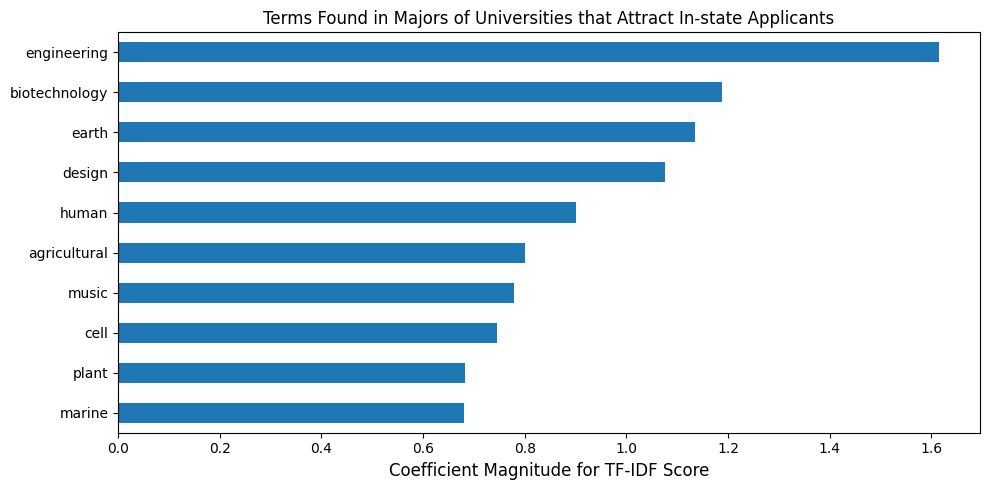

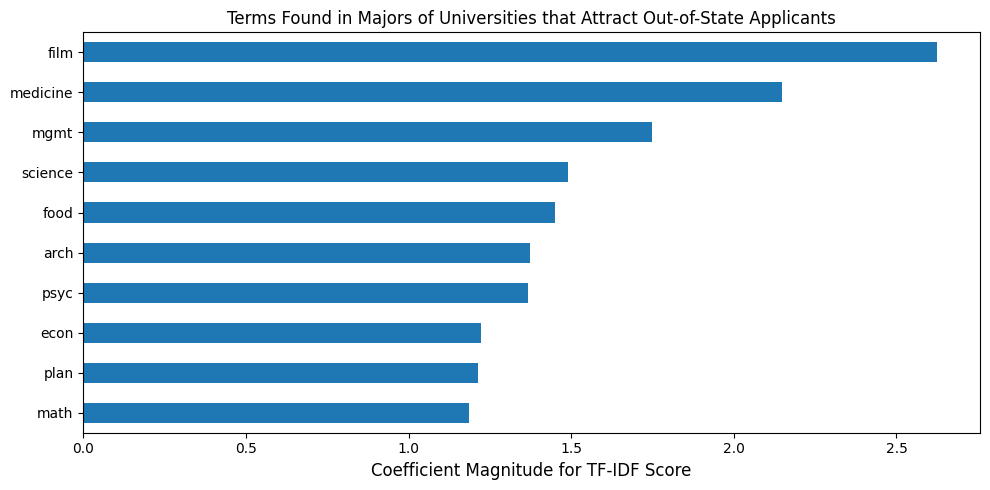

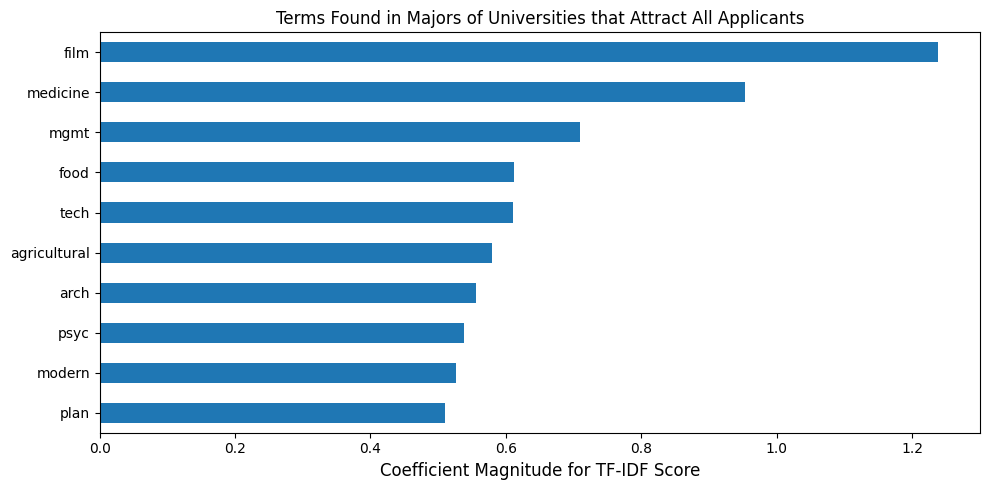

In [14]:
import matplotlib.pyplot as plt

# Plot the top 10 highest magnitude coefficients for 'in' model
ax = model_in.params.drop('const').nlargest(10).sort_values().plot(kind='barh', figsize=(10, 5), title='Terms Found in Majors of Universities that Attract In-state Applicants')
ax.set_xlabel('Coefficient Magnitude for TF-IDF Score', fontsize=12)
plt.tight_layout()
plt.show()

# Plot the top 10 highest magnitude coefficients for 'out' model
ax = model_out.params.drop('const').nlargest(10).sort_values().plot(kind='barh', figsize=(10, 5), title='Terms Found in Majors of Universities that Attract Out-of-State Applicants')
ax.set_xlabel('Coefficient Magnitude for TF-IDF Score', fontsize=12)
plt.tight_layout()
plt.show()

# Plot the top 10 highest magnitude coefficients for 'total' model
ax = model_total.params.drop('const').nlargest(10).sort_values().plot(kind='barh', figsize=(10, 5), title='Terms Found in Majors of Universities that Attract All Applicants')
ax.set_xlabel('Coefficient Magnitude for TF-IDF Score', fontsize=12)
plt.tight_layout()
plt.show()


### Finishing up with a simple count of term frequency among students staying in vs out of state, this seemed less informative overall so I focused on the above

In [15]:
from collections import Counter

# Filter the data based on 'stayed_in_state' column
stayed_in_state_data = filtered_data[filtered_data['stayed_in_state'] == 1]
stayed_out_of_state_data = filtered_data[filtered_data['stayed_in_state'] == 0]

# Word frequency count for 'Enrollment Major 1' column where 'stayed_in_state' = 1
word_freq_stayed_in_state = Counter(" ".join(stayed_in_state_data['Enrollment Major 1'].dropna()).split())

# Word frequency count for 'Enrollment Major 1' column where 'stayed_in_state' = 0
word_freq_stayed_out_of_state = Counter(" ".join(stayed_out_of_state_data['Enrollment Major 1'].dropna()).split())

# Print the top 10 most common words for each category
print("Top 30 most common words for 'stayed_in_state' = 1:")
print(word_freq_stayed_in_state.most_common(30))

print("\nTop 30 most common words for 'stayed_in_state' = 0:")
print(word_freq_stayed_out_of_state.most_common(30))

Top 30 most common words for 'stayed_in_state' = 1:
[('SCIENCE', 407), ('BUSINESS', 402), ('PRE', 329), ('STUDIES', 270), ('GENERAL', 268), ('PSYCHOLOGY', 225), ('UNDECLARED', 214), ('SCIENCES', 208), ('EDUCATION', 197), ('BIOLOGY', 195), ('ENGINEERING', 193), ('NURSING', 183), ('BS', 173), ('AND', 154), ('ADMINISTRATION', 149), ('ASSOCIATE', 133), ('ENVIRONMENTAL', 126), ('HEALTH', 116), ('ARTS', 110), ('UNDERGRADUATE', 109), ('DEGREE-SEEKING', 107), ('OF', 96), ('&', 90), ('ELEMENTARY', 88), ('MAJOR', 86), ('KINESIOLOGY', 86), ('COMPUTER', 85), ('MANAGEMENT', 85), ('INTEREST', 82), ('SCI', 80)]

Top 30 most common words for 'stayed_in_state' = 0:
[('BUSINESS', 511), ('SCIENCE', 465), ('UNDECLARED', 376), ('PRE', 293), ('STUDIES', 251), ('SCIENCES', 209), ('PSYCHOLOGY', 208), ('ENGINEERING', 204), ('BIOLOGY', 197), ('BS', 192), ('IN', 184), ('ADMINISTRATION', 168), ('AND', 163), ('OF', 156), ('ENVIRONMENTAL', 150), ('BACHELOR', 145), ('GENERAL', 143), ('MANAGEMENT', 135), ('MAJOR', 12

### Recommendations coming out of this analysis, especially when taken together with other analyses of applicants suggests to me that targeted advertising which brands UM differently for in-state vs out-of-state students may be an effective approach.